# Machine Learning (COSC 522)
## Project 1

## Mount Google Drive Folder (For Google Collab)

In [7]:
# Import Jupyter Widgets
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display

In [8]:
# Clone the repository if you're in Google Collab
# from google.colab import drive
# drive.mount('/content/drive', force_remount=False)
def mount_and_change_dir(is_collab: bool = False):
    from google.colab import drive
    # Mount Google Drive
    drive.mount('/content/drive', force_remount=False)
    # Set working directory
    project_path = '/content/drive/MyDrive/Projects/UTK/COSC522'
    os.chdir(project_path)
    print(os.listdir(project_path))
       
print("Are you on Google Collab?")
btn = widgets.Button(description="Yes")
btn.on_click(mount_and_change_dir)
display(btn)

Are you on Google Collab?


Button(description='Yes', style=ButtonStyle())

## Initializations

In [9]:
# Imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
from scipy.stats import uniform, gaussian_kde, norm
from typing import *
from tqdm.notebook import tqdm

sns.set_style('darkgrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the two datasets and Preprocessing

In [10]:
# Located in <project root>/custom_libs/Project1
import custom_libs.Project1.data_loader as dl

In [11]:
# Create a Data Loader
data_loader = dl.DataLoader(synth_path='data/synth.te', pima_path='data/pima.tr')

In [12]:
# Print Statistics
data_loader.print_statistics()

-- synth_tr --
	Shape: (250, 3)
	Type: float64
	Mean:
		[-0.07275796  0.50436193  0.5       ] (..)
	Max:
		[0.8612962  1.09317811 1.        ] (..)
	Min:
		[-1.24652451 -0.19131316  0.        ] (..)
	Head:
		[0.05100797 0.16086164 0.        ] (..)
-- synth_tr --
	Shape: (250, 3)
	Type: float64
	Mean:
		[-0.07275796  0.50436193  0.5       ] (..)
	Max:
		[0.8612962  1.09317811 1.        ] (..)
	Min:
		[-1.24652451 -0.19131316  0.        ] (..)
	Head:
		[0.05100797 0.16086164 0.        ] (..)
-- pima_tr --
	Shape: (200, 8)
	Type: float64
	Mean:
		[  3.57  123.97   71.26   29.215] (..)
	Max:
		[ 14. 199. 110.  99.] (..)
	Min:
		[ 0. 56. 38.  7.] (..)
	Head:
		[ 5. 86. 68. 28.] (..)
-- pima_te --
	Shape: (332, 8)
	Type: float64
	Mean:
		[  3.48493976 119.25903614  71.65361446  29.1626506 ] (..)
	Max:
		[ 17. 197. 110.  63.] (..)
	Min:
		[ 0. 65. 24.  7.] (..)
	Head:
		[  6. 148.  72.  35.] (..)


In [13]:
# Normalize Pimada
data_loader.normalize_pima(print_statistics=True)

-- pima_tr --
	Shape: (200, 8)
	Type: float64
	Mean:
		[ 4.10782519e-17  5.66213743e-17 -4.06896739e-16  1.36002321e-17] (..)
	Max:
		[3.10616203 2.37527224 3.38314936 5.96695452] (..)
	Min:
		[-1.06318298 -2.15176934 -2.90458306 -1.89948979] (..)
	Head:
		[ 0.42586881 -1.20204034 -0.28469455 -0.10388837] (..)
-- pima_te --
	Shape: (332, 8)
	Type: float64
	Mean:
		[-0.02533182 -0.14913797  0.0343742  -0.00447613] (..)
	Max:
		[3.99959311 2.31195697 3.38314936 2.88878066] (..)
	Min:
		[-1.06318298 -1.86685064 -4.1271977  -1.89948979] (..)
	Head:
		[0.72367917 0.76073293 0.06462392 0.49464544] (..)


In [14]:
# Get the two datasets
synth_te, synth_tr, pima_tr, pima_te = data_loader.get_datasets()

### Plot data

In [15]:
# Located in <project root>/custom_libs/Project1
import custom_libs.Project1.plotter as pl

/home/drkostas/GDrive/Projects/UTK/COSC522/custom_libs/Project1/plotter.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


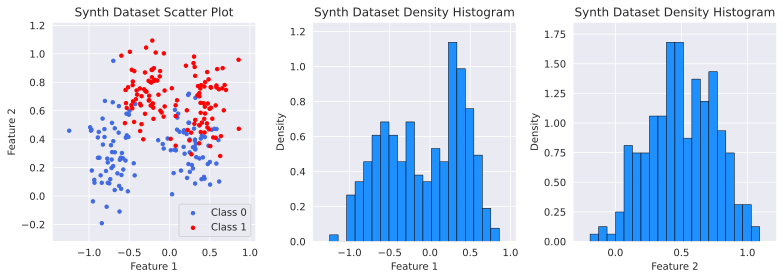

In [16]:
plotter = pl.Plotter(synth_tr, synth_te, pima_tr, pima_te)
plotter.plot_dataset()

## Task 1

### KNN Algorithm

In [17]:
class kNN:
  """ K Nearest Neighbors Alogirithm. """

  accuracy: float
  classwise_accuracy: List[float]
  prediction_time: float
  predicted_y: np.ndarray
  k: int
  train_x: np.ndarray
  train_y: np.ndarray
  test_x: np.ndarray
  test_y: np.ndarray
  predicted_y: np.ndarray
  unique_classes: np.ndarray

  def __init__(self, train: np.ndarray, k: int) -> None:
    # Split train dataset into x and y    
    self.train_x, self.train_y = self.x_y_split(train)
    
    self.k = k
    self.unique_classes = np.unique(self.train_y)

  @staticmethod
  def x_y_split(dataset:np.ndarray) -> Tuple[np.array, np.array]:
    return dataset[:, :-1], dataset[:, -1].astype(int)

  @staticmethod
  def euclidian_distance(a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))

  def find_neighbors(self, test_x: np.ndarray) -> np.array:
    # num_test x num_train: distances from each test point to every train point
    distances = [self.euclidian_distance(test_point, self.train_x) for test_point in test_x]
    # Get k nearest neighbors for each point
    neighbors = []
    # neighbor_distances = []
    for point_distance in distances:
      # Sort distances and get indices
      curr_sorted_distance_idx = np.argsort(point_distance)
      # Get k shortest distnance indices
      curr_closest_neighbors = curr_sorted_distance_idx[:self.k+1]
      # Get k shortest distnances
      # curr_closest_neighbor_distances = point_distance[curr_closest_neighbors]
      # Save them to lists
      neighbors.append(curr_closest_neighbors)
      # neighbor_distances.append(curr_closest_neighbor_distances)

    return np.array(neighbors)

  def fit(self, test: np.ndarray):
    self.test_x, self.test_y = self.x_y_split(test)
    start = time()
    # Get neighbors from the train set
    neighbors = self.find_neighbors(self.test_x)
    # Predict the classes
    predicted_y = [np.argmax(np.bincount(self.train_y[neighbor])) for neighbor in neighbors]    
    self.predicted_y = np.array(predicted_y)
    # Save time
    self.prediction_time = time() - start
  
  def get_statistics(self) -> Tuple[float, List[float], float]:

    self.accuracy = np.count_nonzero(self.predicted_y == self.test_y) / len(self.predicted_y)
    self.classwise_accuracy = []
    for class_n in self.unique_classes:
      test_y_current = self.test_y[self.test_y == self.unique_classes[class_n]]
      predicted_y_current = self.predicted_y[self.test_y == self.unique_classes[class_n]]
      current_acc = np.count_nonzero(predicted_y_current == test_y_current) / len(predicted_y_current)
      self.classwise_accuracy.append(current_acc)

    return self.accuracy, self.classwise_accuracy, self.prediction_time


In [18]:
# kNN for the Synthetic Dataset for k = 2
k = 2
knn_synth = kNN(k=k, train=synth_tr)
knn_synth.fit(synth_te)
synth_accuracy, synth_classwise_accuracy, synth_prediction_time = knn_synth.get_statistics()
print(f"kNN (k={k})  for the Synthetic dataset")
print(f"The overall accuracy is: {synth_accuracy:.4f}")
print(f"The classwise accuracies are: {synth_classwise_accuracy}")
print(f"Total time: {synth_prediction_time:.4f} sec(s)")

kNN (k=2)  for the Synthetic dataset
The overall accuracy is: 0.8660
The classwise accuracies are: [0.898, 0.834]
Total time: 0.0344 sec(s)


In [125]:
# kNN for the Pima Dataset for k = 2
k = 2
knn_pima = kNN(k=k, train=pima_tr)
knn_pima.fit(pima_te)
pima_accuracy, pima_classwise_accuracy, pima_prediction_time = knn_pima.get_statistics()
print(f"kNN (k={k}) for the Pima dataset")
print(f"The overall accuracy is: {pima_accuracy:.4f}")
print(f"The classwise accuracies are: {pima_classwise_accuracy}")
print(f"Total time: {pima_prediction_time:.4f} sec(s)")

kNN (k=2) for the Pima dataset
The overall accuracy is: 0.7410
The classwise accuracies are: [0.5229357798165137, 0.8475336322869955]
Total time: 0.0141 sec(s)


### Plot 1x2 figure (overall accuracy vs k) 

In [126]:
def gather_statistics(train: np.ndarray, test: np.ndarray) -> Tuple[List, List, List, List]:
  """ Function that gathers statistics running kNN for input dataset. """

  max_k = int(np.ceil(np.sqrt(train.shape[0]+1)))
  k_range = list(range(max_k+1))
  # Run for each k
  accuracies = []
  classwise_accuracies = []
  prediction_times = []
  for k in tqdm(k_range):
    knn_model = kNN(k=k, train=train)
    knn_model.fit(test)
    accuracy, classwise_accuracy, prediction_time = knn_model.get_statistics()
    accuracies.append(accuracy)
    classwise_accuracies.append(classwise_accuracy)
    prediction_times.append(prediction_time)

  return k_range, accuracies, classwise_accuracies, prediction_times

In [127]:
# Get statistics for Synthetic Dataset
synth_k_range, synth_accuracies, synth_classwise_accuracies, synth_prediction_times = gather_statistics(synth_tr, synth_te)

  0%|          | 0/17 [00:00<?, ?it/s]

In [128]:
# Get statistics for Pima Dataset
pima_k_range, pima_accuracies, pima_classwise_accuracies, pima_prediction_times = gather_statistics(pima_tr, pima_te)

  0%|          | 0/16 [00:00<?, ?it/s]

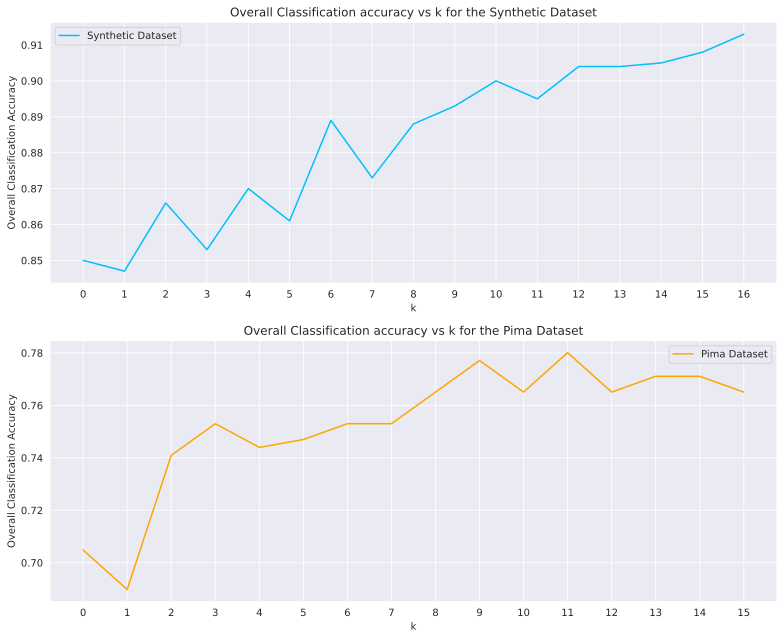

In [129]:
fig, ax = plt.subplots(2, 1, figsize=(11, 9))

# Synth Dataset
ax[0].plot(synth_k_range, synth_accuracies, label='Synthetic Dataset', color='deepskyblue')
ax[0].set_title('Overall Classification accuracy vs k for the Synthetic Dataset')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Overall Classification Accuracy')
_ = ax[0].set_xticks(synth_k_range)
ax[0].legend()
# Pima Dataset
ax[1].plot(pima_k_range, pima_accuracies, label='Pima Dataset', color='orange')
ax[1].set_title('Overall Classification accuracy vs k for the Pima Dataset')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Overall Classification Accuracy')
_ = ax[1].set_xticks(pima_k_range)
ax[1].legend()
# Show plot
fig.tight_layout()
fig.show()